In [7]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,root_mean_squared_error
import pickle

In [8]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='/workspaces/mlops-zoomcamp/02-experiment-tracking/mlruns/1', creation_time=1747770043205, experiment_id='1', last_update_time=1747770043205, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [9]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')

In [10]:
df.head()

VendorID lpep_pickup_datetime lpep_dropoff_datetime store_and_fwd_flag  \
0         2  2021-01-01 00:15:56   2021-01-01 00:19:52                  N   
1         2  2021-01-01 00:25:59   2021-01-01 00:34:44                  N   
2         2  2021-01-01 00:45:57   2021-01-01 00:51:55                  N   
3         2  2020-12-31 23:57:51   2021-01-01 00:04:56                  N   
4         2  2021-01-01 00:16:36   2021-01-01 00:16:40                  N   

   RatecodeID  PULocationID  DOLocationID  passenger_count  trip_distance  \
0         1.0            43           151              1.0           1.01   
1         1.0           166           239              1.0           2.53   
2         1.0            41            42              1.0           1.12   
3         1.0           168            75              1.0           1.99   
4         2.0           265           265              3.0           0.00   

   fare_amount  extra  mta_tax  tip_amount  tolls_amount ehail_fee  \
0          5.5    0.5      0.5        0.00           0.0      None   
1         10.0    0.5      0.5        2.81           0.0      None   
2          6.0    0.5      0.5        1.00           0.0      None   
3          8.0    0.5      0.5        0.00           0.0      None   
4        -52.0    0.0     -0.5        0.00           0.0      None   

   improvement_surcharge  total_amount  payment_type  trip_type  \
0                    0.3          6.80           2.0        1.0   
1                    0.3         16.86           1.0        1.0   
2                    0.3          8.30           1.0        1.0   
3                    0.3          9.30           2.0        1.0   
4                   -0.3        -52.80           3.0        1.0   

   congestion_surcharge  
0                  0.00  
1                  2.75  
2                  0.00  
3                  0.00  
4                  0.00

In [11]:
df.shape

(76518, 20)

In [12]:
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime

In [13]:
df['duration'] = df.duration.dt.total_seconds() / 60

/tmp/ipykernel_2423/3411919821.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['duration']);


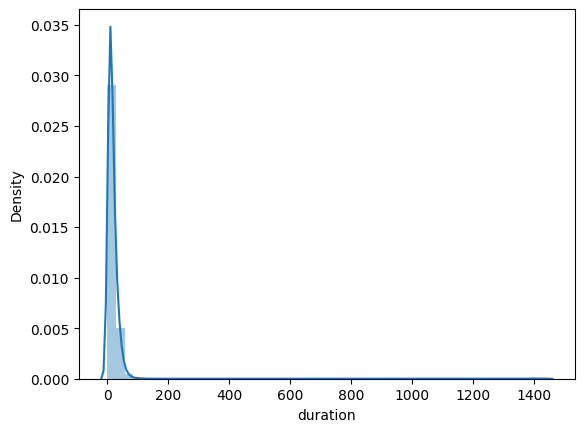

In [14]:
sns.distplot(df['duration']);

In [15]:
df['duration'].describe()

count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
25%          8.000000
50%         13.883333
75%         23.000000
max       1439.600000
Name: duration, dtype: float64

In [16]:
df = df[(df.duration >= 1) & (df.duration <= 60)].copy()

In [17]:
categorical = ['PULocationID', 'DOLocationID']

In [18]:
df[categorical] = df[categorical].astype(str)

In [19]:
train_dicts = df[categorical].to_dict(orient='records')

In [20]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [21]:
target = 'duration'
y_train = df[target].values

In [22]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

In [23]:
print(f'Train RMSE: {root_mean_squared_error(y_train, y_pred)}')

Train RMSE: 9.775596030330492


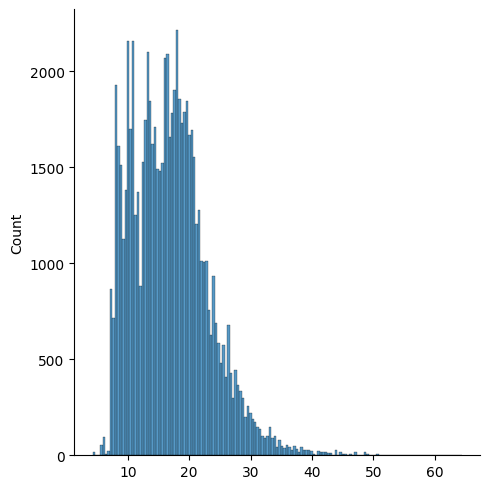

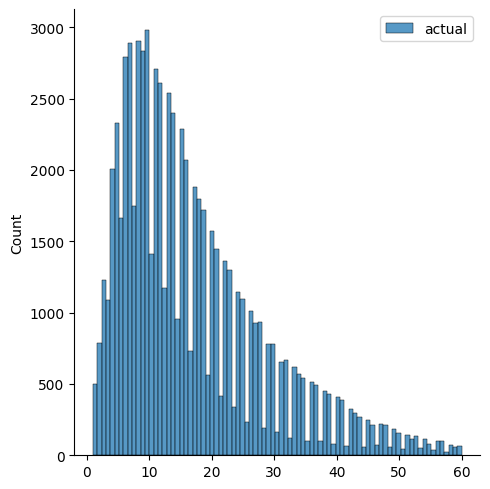

In [24]:
sns.displot(y_pred, label='prediction');
sns.displot(y_train, label='actual');

plt.legend();

In [25]:
y_pred

array([ 7.1795508 , 13.5826054 ,  8.5030211 , ..., 14.09772184,
       16.82464724, 19.46755527])

In [26]:
categorical = ['PULocationID', 'DOLocationID']

def read_data(filename):
    df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.dt.total_seconds() / 60

    df = df[(df.duration >= 1) & (df.duration <= 60)].copy()

    df[categorical] = df[categorical].astype('str')
    
    return df

In [27]:
df_val = read_data('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet')

In [28]:
val_dicts = df_val[categorical].to_dict(orient='records')

In [29]:
X_val = dv.transform(val_dicts) 
y_val = df_val.duration.values

In [30]:
y_pred = lr.predict(X_val)
print(f'Val RMSE: {root_mean_squared_error(y_val, y_pred)}')

Val RMSE: 10.473740383612524


In [33]:
with open('./models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [34]:
with mlflow.start_run():
    mlflow.set_tag("developer","avt")
    mlflow.log_param("train-data-path","https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet")
    mlflow.log_param("val-data-path","https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet")

    alpha = 0.01
    mlflow.log_param("alpha", alpha)

    lr = LinearRegression()
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_train)
    y_pred = lr.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse",rmse)

In [2]:
import xgboost as xgb

In [3]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [32]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [33]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [34]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

[0]	validation-rmse:10.26452                          
[1]	validation-rmse:9.67989                           
  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:23:13] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:9.44117                           
[3]	validation-rmse:9.25156                           
[4]	validation-rmse:9.01683                           
[5]	validation-rmse:8.88777                           
[6]	validation-rmse:8.64725                           
[7]	validation-rmse:8.59122                           
[8]	validation-rmse:8.47701                           
[9]	validation-rmse:8.36256                           
[10]	validation-rmse:8.28374                          
[11]	validation-rmse:8.17670                          
[12]	validation-rmse:8.10179                          
[13]	validation-rmse:8.05560                          
[14]	validation-rmse:7.98990                          
[15]	validation-rmse:7.94565                          
[16]	validation-rmse:7.92931                          
[17]	validation-rmse:7.88934                          
[18]	validation-rmse:7.87409                          
[19]	validation-rmse:7.85345                          
[20]	valid

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:23:19] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:9.62845                                                    
[2]	validation-rmse:9.05053                                                    
[3]	validation-rmse:8.87308                                                    
[4]	validation-rmse:8.53432                                                    
[5]	validation-rmse:8.36913                                                    
[6]	validation-rmse:8.21009                                                    
[7]	validation-rmse:8.00771                                                    
[8]	validation-rmse:7.95796                                                    
[9]	validation-rmse:7.90319                                                    
[10]	validation-rmse:7.82914                                                   
[11]	validation-rmse:7.77061                                                   
[12]	validation-rmse:7.72148                                                   
[13]	validation-rmse:7.70853            

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:25:21] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:10.63157                                                    
[2]	validation-rmse:10.15134                                                    
[3]	validation-rmse:9.74647                                                     
[4]	validation-rmse:9.37151                                                     
[5]	validation-rmse:9.20543                                                     
[6]	validation-rmse:8.92320                                                     
[7]	validation-rmse:8.78650                                                     
[8]	validation-rmse:8.65963                                                     
[9]	validation-rmse:8.58700                                                     
[10]	validation-rmse:8.50840                                                    
[11]	validation-rmse:8.44834                                                    
[12]	validation-rmse:8.29649                                                    
[13]	validation-rmse:8.21732

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:28:11] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.17855                                                      
[1]	validation-rmse:9.24836                                                       
[2]	validation-rmse:8.89396                                                       
[3]	validation-rmse:8.42720                                                       
[4]	validation-rmse:8.28859                                                       
[5]	validation-rmse:8.16176                                                       
[6]	validation-rmse:7.95268                                                       
[7]	validation-rmse:7.73013                                                       
[8]	validation-rmse:7.66518                                                       
[9]	validation-rmse:7.57184                                                       
[10]	validation-rmse:7.53859                                                      
[11]	validation-rmse:7.51760                                                      
[12]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:30:12] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:10.17272                                                      
[4]	validation-rmse:9.96358                                                       
[5]	validation-rmse:9.76350                                                       
[6]	validation-rmse:9.66656                                                       
[7]	validation-rmse:9.47678                                                       
[8]	validation-rmse:9.32065                                                       
[9]	validation-rmse:9.26116                                                       
[10]	validation-rmse:9.22001                                                      
[11]	validation-rmse:9.06136                                                      
[12]	validation-rmse:9.00957                                                      
[13]	validation-rmse:8.94422                                                      
[14]	validation-rmse:8.89865                                                      
[15]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:31:19] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:11.42769                                                      
[3]	validation-rmse:11.21969                                                      
[4]	validation-rmse:11.03881                                                      
[5]	validation-rmse:10.87241                                                      
[6]	validation-rmse:10.72819                                                      
[7]	validation-rmse:10.59113                                                      
[8]	validation-rmse:10.46134                                                      
[9]	validation-rmse:10.35838                                                      
[10]	validation-rmse:10.25509                                                     
[11]	validation-rmse:10.15423                                                     
[12]	validation-rmse:10.08277                                                     
[13]	validation-rmse:9.98723                                                      
[14]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:32:40] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:10.71999                                                     
[2]	validation-rmse:10.28647                                                     
[3]	validation-rmse:10.04293                                                     
[4]	validation-rmse:9.83649                                                      
[5]	validation-rmse:9.57859                                                      
[6]	validation-rmse:9.47698                                                      
[7]	validation-rmse:9.35449                                                      
[8]	validation-rmse:9.29472                                                      
[9]	validation-rmse:9.15524                                                      
[10]	validation-rmse:9.08846                                                     
[11]	validation-rmse:9.04029                                                     
[12]	validation-rmse:8.98177                                                     
[13]	validation-

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:33:56] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:10.60499                                                     
[3]	validation-rmse:10.28803                                                     
[4]	validation-rmse:9.95747                                                      
[5]	validation-rmse:9.70524                                                      
[6]	validation-rmse:9.55129                                                      
[7]	validation-rmse:9.31616                                                      
[8]	validation-rmse:9.21528                                                      
[9]	validation-rmse:9.04926                                                      
[10]	validation-rmse:8.95861                                                     
[11]	validation-rmse:8.82200                                                     
[12]	validation-rmse:8.74077                                                     
[13]	validation-rmse:8.69243                                                     
[14]	validation-

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:36:44] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[6]	validation-rmse:11.06458                                                      
[7]	validation-rmse:11.01820                                                      
[8]	validation-rmse:10.94956                                                      
[9]	validation-rmse:10.91485                                                      
[10]	validation-rmse:10.87029                                                     
[11]	validation-rmse:10.82313                                                     
[12]	validation-rmse:10.77939                                                     
[13]	validation-rmse:10.73595                                                     
[14]	validation-rmse:10.70697                                                     
[15]	validation-rmse:10.67388                                                     
[16]	validation-rmse:10.64938                                                     
[17]	validation-rmse:10.62069                                                     
[18]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:37:02] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[10]	validation-rmse:10.86947                                                  
[11]	validation-rmse:10.81291                                                  
[12]	validation-rmse:10.76676                                                  
[13]	validation-rmse:10.73848                                                  
[14]	validation-rmse:10.68551                                                  
[15]	validation-rmse:10.65621                                                  
[16]	validation-rmse:10.61354                                                  
[17]	validation-rmse:10.58970                                                  
[18]	validation-rmse:10.53914                                                  
[19]	validation-rmse:10.50533                                                  
[20]	validation-rmse:10.46987                                                  
[21]	validation-rmse:10.44835                                                  
[22]	validation-rmse:10.42795           

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:37:29] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:8.39482                                                     
[3]	validation-rmse:8.24357                                                     
[4]	validation-rmse:8.11178                                                     
[5]	validation-rmse:7.99095                                                     
[6]	validation-rmse:7.90463                                                     
[7]	validation-rmse:7.83377                                                     
[8]	validation-rmse:7.80046                                                     
[9]	validation-rmse:7.78866                                                     
[10]	validation-rmse:7.77961                                                    
[11]	validation-rmse:7.76176                                                    
[12]	validation-rmse:7.75564                                                    
[13]	validation-rmse:7.74961                                                    
[14]	validation-rmse:7.75181

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:39:11] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:10.87663                                                    
[3]	validation-rmse:10.57671                                                    
[4]	validation-rmse:10.27795                                                    
[5]	validation-rmse:10.07228                                                    
[6]	validation-rmse:9.85300                                                     
[7]	validation-rmse:9.67410                                                     
[8]	validation-rmse:9.50168                                                     
[9]	validation-rmse:9.35901                                                     
[10]	validation-rmse:9.26825                                                    
[11]	validation-rmse:9.19148                                                    
[12]	validation-rmse:9.05411                                                    
[13]	validation-rmse:8.95398                                                    
[14]	validation-rmse:8.89819

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:41:11] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[4]	validation-rmse:10.46909                                                    
[5]	validation-rmse:10.34305                                                    
[6]	validation-rmse:10.18641                                                    
[7]	validation-rmse:10.01712                                                    
[8]	validation-rmse:9.94798                                                     
[9]	validation-rmse:9.86073                                                     
[10]	validation-rmse:9.74895                                                    
[11]	validation-rmse:9.70538                                                    
[12]	validation-rmse:9.64155                                                    
[13]	validation-rmse:9.59682                                                    
[14]	validation-rmse:9.54608                                                    
[15]	validation-rmse:9.51410                                                    
[16]	validation-rmse:9.42814

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:42:02] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:11.14679                                                    
[4]	validation-rmse:10.98057                                                    
[5]	validation-rmse:10.83368                                                    
[6]	validation-rmse:10.68020                                                    
[7]	validation-rmse:10.56925                                                    
[8]	validation-rmse:10.44398                                                    
[9]	validation-rmse:10.37331                                                    
[10]	validation-rmse:10.27153                                                   
[11]	validation-rmse:10.19700                                                   
[12]	validation-rmse:10.14208                                                   
[13]	validation-rmse:10.06176                                                   
[14]	validation-rmse:10.02178                                                   
[15]	validation-rmse:9.97521

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:42:45] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[7]	validation-rmse:10.06545                                                    
[8]	validation-rmse:10.00680                                                    
[9]	validation-rmse:9.94712                                                     
[10]	validation-rmse:9.88971                                                    
[11]	validation-rmse:9.85089                                                    
[12]	validation-rmse:9.75496                                                    
[13]	validation-rmse:9.68983                                                    
[14]	validation-rmse:9.65807                                                    
[15]	validation-rmse:9.58825                                                    
[16]	validation-rmse:9.56091                                                    
[17]	validation-rmse:9.51538                                                    
[18]	validation-rmse:9.49255                                                    
[19]	validation-rmse:9.46231

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:43:03] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[14]	validation-rmse:10.45678                                                   
[15]	validation-rmse:10.40536                                                   
[16]	validation-rmse:10.37124                                                   
[17]	validation-rmse:10.34574                                                   
[18]	validation-rmse:10.32152                                                   
[19]	validation-rmse:10.30227                                                   
[20]	validation-rmse:10.27665                                                   
[21]	validation-rmse:10.25793                                                   
[22]	validation-rmse:10.22447                                                   
[23]	validation-rmse:10.19447                                                   
[24]	validation-rmse:10.17041                                                   
[25]	validation-rmse:10.14270                                                   
[26]	validation-rmse:10.1148

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:43:25] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:10.59873                                                    
[3]	validation-rmse:10.25328                                                    
[4]	validation-rmse:10.02596                                                    
[5]	validation-rmse:9.75720                                                     
[6]	validation-rmse:9.57490                                                     
[7]	validation-rmse:9.39740                                                     
[8]	validation-rmse:9.28143                                                     
[9]	validation-rmse:9.16294                                                     
[10]	validation-rmse:9.09395                                                    
[11]	validation-rmse:8.97386                                                    
[12]	validation-rmse:8.93193                                                    
[13]	validation-rmse:8.88074                                                    
[14]	validation-rmse:8.77970

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:45:19] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[11]	validation-rmse:11.71059                                                   
[12]	validation-rmse:11.68953                                                   
[13]	validation-rmse:11.66422                                                   
[14]	validation-rmse:11.64362                                                   
[15]	validation-rmse:11.62203                                                   
[16]	validation-rmse:11.60368                                                   
[17]	validation-rmse:11.58824                                                   
[18]	validation-rmse:11.56878                                                   
[19]	validation-rmse:11.55144                                                   
[20]	validation-rmse:11.53689                                                   
[21]	validation-rmse:11.52317                                                   
[22]	validation-rmse:11.50806                                                   
[23]	validation-rmse:11.4924

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:45:33] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:9.83721                                                     
[4]	validation-rmse:9.72901                                                     
[5]	validation-rmse:9.48691                                                     
[6]	validation-rmse:9.38203                                                     
[7]	validation-rmse:9.26621                                                     
[8]	validation-rmse:9.17092                                                     
[9]	validation-rmse:9.06942                                                     
[10]	validation-rmse:9.00772                                                    
[11]	validation-rmse:8.91988                                                    
[12]	validation-rmse:8.87533                                                    
[13]	validation-rmse:8.81385                                                    
[14]	validation-rmse:8.71837                                                    
[15]	validation-rmse:8.68119

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:46:39] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:11.43630                                                    
[4]	validation-rmse:11.28069                                                    
[5]	validation-rmse:11.13953                                                    
[6]	validation-rmse:11.01350                                                    
[7]	validation-rmse:10.89533                                                    
[8]	validation-rmse:10.78309                                                    
[9]	validation-rmse:10.67721                                                    
[10]	validation-rmse:10.57605                                                   
[11]	validation-rmse:10.49829                                                   
[12]	validation-rmse:10.40866                                                   
[13]	validation-rmse:10.32727                                                   
[14]	validation-rmse:10.26595                                                   
[15]	validation-rmse:10.2043

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:47:48] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:10.75537                                                    
[4]	validation-rmse:10.50924                                                    
[5]	validation-rmse:10.33132                                                    
[6]	validation-rmse:10.16815                                                    
[7]	validation-rmse:10.03089                                                    
[8]	validation-rmse:9.92348                                                     
[9]	validation-rmse:9.81601                                                     
[10]	validation-rmse:9.70046                                                    
[11]	validation-rmse:9.61208                                                    
[12]	validation-rmse:9.55266                                                    
[13]	validation-rmse:9.50168                                                    
[14]	validation-rmse:9.45743                                                    
[15]	validation-rmse:9.38167

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:49:04] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.85813                                                    
[1]	validation-rmse:11.55148                                                    
[2]	validation-rmse:11.28028                                                    
[3]	validation-rmse:11.02080                                                    
[4]	validation-rmse:10.81960                                                    
[5]	validation-rmse:10.62676                                                    
[6]	validation-rmse:10.47586                                                    
[7]	validation-rmse:10.30297                                                    
[8]	validation-rmse:10.17086                                                    
[9]	validation-rmse:10.07020                                                    
[10]	validation-rmse:9.96417                                                    
[11]	validation-rmse:9.86912                                                    
[12]	validation-rmse:9.79604

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:50:23] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:10.82772                                                    
[4]	validation-rmse:10.62150                                                    
[5]	validation-rmse:10.43996                                                    
[6]	validation-rmse:10.29346                                                    
[7]	validation-rmse:10.15679                                                    
[8]	validation-rmse:10.03745                                                    
[9]	validation-rmse:9.93150                                                     
[10]	validation-rmse:9.85767                                                    
[11]	validation-rmse:9.74089                                                    
[12]	validation-rmse:9.68735                                                    
[13]	validation-rmse:9.61229                                                    
[14]	validation-rmse:9.56410                                                    
[15]	validation-rmse:9.51341

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:51:29] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:11.19082                                                    
[4]	validation-rmse:10.97648                                                    
[5]	validation-rmse:10.78977                                                    
[6]	validation-rmse:10.63853                                                    
[7]	validation-rmse:10.48054                                                    
[8]	validation-rmse:10.36241                                                    
[9]	validation-rmse:10.22542                                                    
[10]	validation-rmse:10.11232                                                   
[11]	validation-rmse:10.00458                                                   
[12]	validation-rmse:9.93101                                                    
[13]	validation-rmse:9.84158                                                    
[14]	validation-rmse:9.76400                                                    
[15]	validation-rmse:9.66894

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:52:49] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:9.58437                                                     
[4]	validation-rmse:9.32363                                                     
[5]	validation-rmse:9.18020                                                     
[6]	validation-rmse:9.04410                                                     
[7]	validation-rmse:8.97510                                                     
[8]	validation-rmse:8.80360                                                     
[9]	validation-rmse:8.71647                                                     
[10]	validation-rmse:8.67427                                                    
[11]	validation-rmse:8.61840                                                    
[12]	validation-rmse:8.52534                                                    
[13]	validation-rmse:8.49220                                                    
[14]	validation-rmse:8.45117                                                    
[15]	validation-rmse:8.42375

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:54:11] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:10.68314                                                    
[2]	validation-rmse:10.08587                                                    
[3]	validation-rmse:9.70726                                                     
[4]	validation-rmse:9.36381                                                     
[5]	validation-rmse:9.06492                                                     
[6]	validation-rmse:8.90725                                                     
[7]	validation-rmse:8.78843                                                     
[8]	validation-rmse:8.60472                                                     
[9]	validation-rmse:8.45338                                                     
[10]	validation-rmse:8.38237                                                    
[11]	validation-rmse:8.27521                                                    
[12]	validation-rmse:8.21974                                                    
[13]	validation-rmse:8.08498

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:57:02] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.55765                                                     
[1]	validation-rmse:11.02090                                                     
[2]	validation-rmse:10.55157                                                     
[3]	validation-rmse:10.15791                                                     
[4]	validation-rmse:9.88550                                                      
[5]	validation-rmse:9.66564                                                      
[6]	validation-rmse:9.40945                                                      
[7]	validation-rmse:9.26004                                                      
[8]	validation-rmse:9.14486                                                      
[9]	validation-rmse:8.96042                                                      
[10]	validation-rmse:8.82415                                                     
[11]	validation-rmse:8.71378                                                     
[12]	validation-

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [19:58:23] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:11.42598                                                    
[2]	validation-rmse:11.09618                                                    
[3]	validation-rmse:10.78530                                                    
[4]	validation-rmse:10.54537                                                    
[5]	validation-rmse:10.30343                                                    
[6]	validation-rmse:10.06913                                                    
[7]	validation-rmse:9.91520                                                     
[8]	validation-rmse:9.72115                                                     
[9]	validation-rmse:9.60910                                                     
[10]	validation-rmse:9.49738                                                    
[11]	validation-rmse:9.34028                                                    
[12]	validation-rmse:9.21553                                                    
[13]	validation-rmse:9.10558

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:01:02] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:9.73611                                                      
[2]	validation-rmse:9.17125                                                      
[3]	validation-rmse:8.93888                                                      
[4]	validation-rmse:8.69152                                                      
[5]	validation-rmse:8.31318                                                      
[6]	validation-rmse:8.18248                                                      
[7]	validation-rmse:8.11747                                                      
[8]	validation-rmse:7.98313                                                      
[9]	validation-rmse:7.87956                                                      
[10]	validation-rmse:7.77766                                                     
[11]	validation-rmse:7.70607                                                     
[12]	validation-rmse:7.66296                                                     
[13]	validation-

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:03:03] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:10.57706                                                     
[3]	validation-rmse:10.23081                                                     
[4]	validation-rmse:9.92709                                                      
[5]	validation-rmse:9.74554                                                      
[6]	validation-rmse:9.55172                                                      
[7]	validation-rmse:9.39179                                                      
[8]	validation-rmse:9.31230                                                      
[9]	validation-rmse:9.22752                                                      
[10]	validation-rmse:9.11126                                                     
[11]	validation-rmse:8.96849                                                     
[12]	validation-rmse:8.91703                                                     
[13]	validation-rmse:8.82117                                                     
[14]	validation-

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:04:50] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:10.03554                                                     
[4]	validation-rmse:9.75732                                                      
[5]	validation-rmse:9.61862                                                      
[6]	validation-rmse:9.51802                                                      
[7]	validation-rmse:9.42607                                                      
[8]	validation-rmse:9.30292                                                      
[9]	validation-rmse:9.25619                                                      
[10]	validation-rmse:9.17573                                                     
[11]	validation-rmse:9.12336                                                     
[12]	validation-rmse:9.08255                                                     
[13]	validation-rmse:9.04480                                                     
[14]	validation-rmse:9.01794                                                     
[15]	validation-

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:06:05] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.19030                                                     
[1]	validation-rmse:9.66118                                                      
[2]	validation-rmse:9.52072                                                      
[3]	validation-rmse:9.33126                                                      
[4]	validation-rmse:9.17352                                                      
[5]	validation-rmse:9.09026                                                      
[6]	validation-rmse:9.04127                                                      
[7]	validation-rmse:8.98479                                                      
[8]	validation-rmse:8.95427                                                      
[9]	validation-rmse:8.92539                                                      
[10]	validation-rmse:8.89668                                                     
[11]	validation-rmse:8.87046                                                     
[12]	validation-

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:07:10] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:9.31112                                                     
[4]	validation-rmse:9.18909                                                     
[5]	validation-rmse:9.12030                                                     
[6]	validation-rmse:9.07082                                                     
[7]	validation-rmse:8.96964                                                     
[8]	validation-rmse:8.91671                                                     
[9]	validation-rmse:8.86479                                                     
[10]	validation-rmse:8.83845                                                    
[11]	validation-rmse:8.79869                                                    
[12]	validation-rmse:8.76318                                                    
[13]	validation-rmse:8.72252                                                    
[14]	validation-rmse:8.69009                                                    
[15]	validation-rmse:8.66166

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:08:24] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[4]	validation-rmse:9.20965                                                     
[5]	validation-rmse:9.10838                                                     
[6]	validation-rmse:9.02415                                                     
[7]	validation-rmse:8.88019                                                     
[8]	validation-rmse:8.82054                                                     
[9]	validation-rmse:8.78931                                                     
[10]	validation-rmse:8.69702                                                    
[11]	validation-rmse:8.66015                                                    
[12]	validation-rmse:8.62759                                                    
[13]	validation-rmse:8.60808                                                    
[14]	validation-rmse:8.58573                                                    
[15]	validation-rmse:8.54590                                                    
[16]	validation-rmse:8.53862

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:09:26] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:8.62484                                                     
[4]	validation-rmse:8.48682                                                     
[5]	validation-rmse:8.38624                                                     
[6]	validation-rmse:8.34054                                                     
[7]	validation-rmse:8.30994                                                     
[8]	validation-rmse:8.28511                                                     
[9]	validation-rmse:8.26157                                                     
[10]	validation-rmse:8.23272                                                    
[11]	validation-rmse:8.20928                                                    
[12]	validation-rmse:8.18925                                                    
[13]	validation-rmse:8.16457                                                    
[14]	validation-rmse:8.14593                                                    
[15]	validation-rmse:8.12377

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:10:53] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:10.09018                                                    
[4]	validation-rmse:9.87207                                                     
[5]	validation-rmse:9.74474                                                     
[6]	validation-rmse:9.61209                                                     
[7]	validation-rmse:9.53879                                                     
[8]	validation-rmse:9.46261                                                     
[9]	validation-rmse:9.34021                                                     
[10]	validation-rmse:9.29444                                                    
[11]	validation-rmse:9.26068                                                    
[12]	validation-rmse:9.22744                                                    
[13]	validation-rmse:9.16630                                                    
[14]	validation-rmse:9.12957                                                    
[15]	validation-rmse:9.09818

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:11:59] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:9.18383                                                     
[4]	validation-rmse:9.05621                                                     
[5]	validation-rmse:8.87954                                                     
[6]	validation-rmse:8.79634                                                     
[7]	validation-rmse:8.72715                                                     
[8]	validation-rmse:8.67819                                                     
[9]	validation-rmse:8.64313                                                     
[10]	validation-rmse:8.61028                                                    
[11]	validation-rmse:8.57913                                                    
[12]	validation-rmse:8.55368                                                    
[13]	validation-rmse:8.53067                                                    
[14]	validation-rmse:8.51443                                                    
[15]	validation-rmse:8.48579

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:13:20] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[6]	validation-rmse:8.76471                                                     
[7]	validation-rmse:8.73116                                                     
[8]	validation-rmse:8.70628                                                     
[9]	validation-rmse:8.68531                                                     
[10]	validation-rmse:8.65664                                                    
[11]	validation-rmse:8.63967                                                    
[12]	validation-rmse:8.62100                                                    
[13]	validation-rmse:8.59523                                                    
[14]	validation-rmse:8.58191                                                    
[15]	validation-rmse:8.56249                                                    
[16]	validation-rmse:8.53695                                                    
[17]	validation-rmse:8.52294                                                    
[18]	validation-rmse:8.50391

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:14:05] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[5]	validation-rmse:9.15846                                                     
[6]	validation-rmse:8.98849                                                     
[7]	validation-rmse:8.88123                                                     
[8]	validation-rmse:8.80456                                                     
[9]	validation-rmse:8.53350                                                     
[10]	validation-rmse:8.47774                                                    
[11]	validation-rmse:8.43084                                                    
[12]	validation-rmse:8.40542                                                    
[13]	validation-rmse:8.35249                                                    
[14]	validation-rmse:8.32633                                                    
[15]	validation-rmse:8.29518                                                    
[16]	validation-rmse:8.26537                                                    
[17]	validation-rmse:8.24918

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:14:52] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[12]	validation-rmse:9.13769                                                    
[13]	validation-rmse:9.10568                                                    
[14]	validation-rmse:9.07463                                                    
[15]	validation-rmse:9.02027                                                    
[16]	validation-rmse:8.92197                                                    
[17]	validation-rmse:8.89191                                                    
[18]	validation-rmse:8.86839                                                    
[19]	validation-rmse:8.81825                                                    
[20]	validation-rmse:8.77670                                                    
[21]	validation-rmse:8.73977                                                    
[22]	validation-rmse:8.72082                                                    
[23]	validation-rmse:8.70415                                                    
[24]	validation-rmse:8.66993

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:15:16] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:9.36377                                                     
[3]	validation-rmse:9.18801                                                     
[4]	validation-rmse:8.87107                                                     
[5]	validation-rmse:8.73766                                                     
[6]	validation-rmse:8.62216                                                     
[7]	validation-rmse:8.38573                                                     
[8]	validation-rmse:8.31486                                                     
[9]	validation-rmse:8.24082                                                     
[10]	validation-rmse:8.19128                                                    
[11]	validation-rmse:8.14995                                                    
[12]	validation-rmse:8.10750                                                    
[13]	validation-rmse:8.06172                                                    
[14]	validation-rmse:8.02377

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:16:37] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:9.08381                                                     
[2]	validation-rmse:8.49066                                                     
[3]	validation-rmse:8.13861                                                     
[4]	validation-rmse:7.97561                                                     
[5]	validation-rmse:7.86099                                                     
[6]	validation-rmse:7.81154                                                     
[7]	validation-rmse:7.73211                                                     
[8]	validation-rmse:7.64178                                                     
[9]	validation-rmse:7.61451                                                     
[10]	validation-rmse:7.58794                                                    
[11]	validation-rmse:7.56882                                                    
[12]	validation-rmse:7.54649                                                    
[13]	validation-rmse:7.53833

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:18:16] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:9.68444                                                     
[4]	validation-rmse:9.38765                                                     
[5]	validation-rmse:9.26426                                                     
[6]	validation-rmse:9.11986                                                     
[7]	validation-rmse:9.03473                                                     
[8]	validation-rmse:8.96923                                                     
[9]	validation-rmse:8.92841                                                     
[10]	validation-rmse:8.87661                                                    
[11]	validation-rmse:8.82992                                                    
[12]	validation-rmse:8.77687                                                    
[13]	validation-rmse:8.75089                                                    
[14]	validation-rmse:8.72508                                                    
[15]	validation-rmse:8.70781

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:19:23] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:8.78193                                                     
[4]	validation-rmse:8.64611                                                     
[5]	validation-rmse:8.57417                                                     
[6]	validation-rmse:8.52750                                                     
[7]	validation-rmse:8.49726                                                     
[8]	validation-rmse:8.47386                                                     
[9]	validation-rmse:8.43999                                                     
[10]	validation-rmse:8.40665                                                    
[11]	validation-rmse:8.38179                                                    
[12]	validation-rmse:8.35323                                                    
[13]	validation-rmse:8.32470                                                    
[14]	validation-rmse:8.30391                                                    
[15]	validation-rmse:8.29217

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:20:24] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:10.11784                                                    
[3]	validation-rmse:9.81782                                                     
[4]	validation-rmse:9.57861                                                     
[5]	validation-rmse:9.44992                                                     
[6]	validation-rmse:9.23890                                                     
[7]	validation-rmse:9.12516                                                     
[8]	validation-rmse:9.03470                                                     
[9]	validation-rmse:8.97568                                                     
[10]	validation-rmse:8.91766                                                    
[11]	validation-rmse:8.85568                                                    
[12]	validation-rmse:8.81283                                                    
[13]	validation-rmse:8.75255                                                    
[14]	validation-rmse:8.71534

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:21:25] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:8.35257                                                     
[3]	validation-rmse:8.19781                                                     
[4]	validation-rmse:8.10675                                                     
[5]	validation-rmse:8.06275                                                     
[6]	validation-rmse:8.01375                                                     
[7]	validation-rmse:7.98462                                                     
[8]	validation-rmse:7.96173                                                     
[9]	validation-rmse:7.94105                                                     
[10]	validation-rmse:7.93096                                                    
[11]	validation-rmse:7.92668                                                    
[12]	validation-rmse:7.92116                                                    
[13]	validation-rmse:7.91528                                                    
[14]	validation-rmse:7.90851

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:22:54] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[4]	validation-rmse:9.27003                                                     
[5]	validation-rmse:9.12130                                                     
[6]	validation-rmse:9.04838                                                     
[7]	validation-rmse:8.97009                                                     
[8]	validation-rmse:8.80901                                                     
[9]	validation-rmse:8.77135                                                     
[10]	validation-rmse:8.72667                                                    
[11]	validation-rmse:8.68161                                                    
[12]	validation-rmse:8.66248                                                    
[13]	validation-rmse:8.63001                                                    
[14]	validation-rmse:8.59943                                                    
[15]	validation-rmse:8.57397                                                    
[16]	validation-rmse:8.55673

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:24:02] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:8.94818                                                       
[3]	validation-rmse:8.79903                                                       
[4]	validation-rmse:8.43860                                                       
[5]	validation-rmse:8.33394                                                       
[6]	validation-rmse:8.22701                                                       
[7]	validation-rmse:8.09524                                                       
[8]	validation-rmse:8.04314                                                       
[9]	validation-rmse:8.00849                                                       
[10]	validation-rmse:7.91857                                                      
[11]	validation-rmse:7.87562                                                      
[12]	validation-rmse:7.85816                                                      
[13]	validation-rmse:7.84225                                                      
[14]

KeyboardInterrupt: 

In [ ]:
Parameter
Value
learning_rate
0.40286019846411053
max_depth
99
min_child_weight
13.829229186553235
objective
reg:linear
reg_alpha
0.026701094387268132
reg_lambda
0.011321203510932446
seed
42

In [35]:
params={'learning_rate':0.40286019846411053,
'max_depth':99,
'min_child_weight':13.829229186553235,
'objective':'reg:linear',
'reg_alpha':0.026701094387268132,
'reg_lambda':0.011321203510932446,
'seed':42}

In [36]:



mlflow.xgboost.autolog()
booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
y_pred = booster.predict(valid)
rmse = root_mean_squared_error(y_val, y_pred)

2025/05/21 20:34:51 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '42cd444a118f46aaa3812ed8150abc18', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow
/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:34:53] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:10.59550
[1]	validation-rmse:9.90489
[2]	validation-rmse:9.38566
[3]	validation-rmse:9.18383
[4]	validation-rmse:9.05621
[5]	validation-rmse:8.87954
[6]	validation-rmse:8.79634
[7]	validation-rmse:8.72715
[8]	validation-rmse:8.67819
[9]	validation-rmse:8.64313
[10]	validation-rmse:8.61028
[11]	validation-rmse:8.57913
[12]	validation-rmse:8.55368
[13]	validation-rmse:8.53067
[14]	validation-rmse:8.51443
[15]	validation-rmse:8.48579
[16]	validation-rmse:8.46878
[17]	validation-rmse:8.44364
[18]	validation-rmse:8.42182
[19]	validation-rmse:8.40291
[20]	validation-rmse:8.37766
[21]	validation-rmse:8.35702
[22]	validation-rmse:8.34064
[23]	validation-rmse:8.32291
[24]	validation-rmse:8.29439
[25]	validation-rmse:8.27199
[26]	validation-rmse:8.25485
[27]	validation-rmse:8.23740
[28]	validation-rmse:8.22060
[29]	validation-rmse:8.20613
[30]	validation-rmse:8.18954
[31]	validation-rmse:8.17695
[32]	validation-rmse:8.16265
[33]	validation-rmse:8.14658
[34]	validation-rmse:8.

2025/05/21 20:36:59 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2025/05/21 20:36:59 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:36:59] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2025/05/21 20:37:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
